# Lid Driven Cavity Problem (Unsteady Case) 
This problem uses Centra Difference in Space and Forward Difference in Time. The tqdm is used to calculate in forward time step. 

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 610.57it/s]


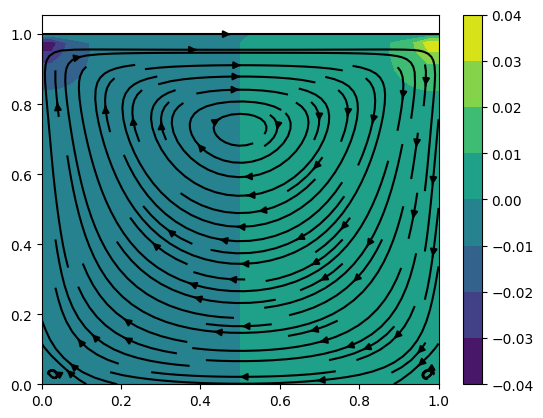

In [23]:
import matplotlib.pyplot as plt
import numpy as np 
from tqdm import tqdm
from matplotlib.animation import FuncAnimation

N_points = 41
Domain_size = 1.0
N_iterations = 1000
time_steps = 0.001
kinematic_viscosity = 0.1
density = 1.0
Horizontal_velocity = 0.01

N_iterations_poisson_pressure = 50

def main():
    element_length = Domain_size/(N_points-1)
    x = np.linspace(0.0, Domain_size, N_points) #discretization in x-direction
    y = np.linspace(0.0, Domain_size, N_points) #discretization in y-direction
    X, Y = np.meshgrid (x,y) #meshing in 2D
    u_prev = np.zeros_like(X) #assigning the intial value of u velocity it is same size as x
    v_prev = np.zeros_like(X) #assigning the intial value of v velocity it is same size as x
    p_prev = np.zeros_like(X) #assigning the intial value of pressure p 

    def central_difference_in_x(f): #Central difference scheme applied in x direction 
        diff = np.zeros_like(f)
        diff[1:-1, 1:-1] = (
            f[1:-1, 2: ] - f[1:-1, 0:-2] #(f(i+1,j)-f(i-1,j))/(2*delta(x))
        )/(2*element_length)
        return diff

    def central_difference_in_y(f): #Cental difference scheme applied in y direction
        diff = np.zeros_like(f)
        diff[1:-1, 1:-1] = (
            f[2: , 1:-1] - f[0:-2, 1:-1] #(f(i,j+1)-f(i,j-1))/(2*delta(x))
        )/(2*element_length)
        return diff

    def laplace(f):                #Central difference scheme for laplacian operator 
        diff = np.zeros_like(f) 
        diff[1:-1, 1:-1] = (
            f[2: ,1:-1] + f[1:-1, 2: ] - (4*f[1:-1, 1:-1]) + f[0:-2, 1:-1] + f[1:-1, 0:-2] #both x and y direction
        )/(element_length)**2 
        return diff

    for _ in tqdm(range(N_iterations)):   #Application of time steping scheme which is equal to forward difference scheme

        #du = delta(t)(-(u*(del_u/del_x) + v*(del_u/del_y))+(nu * laplace(u)))
        #dv = delta(t)(-(u*(del_v/del_x) + v*(del_v/del_y))+(nu * laplace(v)))
        d_u_prev_d_x = central_difference_in_x(u_prev) 
        d_u_prev_d_y = central_difference_in_y(u_prev)
        d_v_prev_d_x = central_difference_in_x(v_prev)
        d_v_prev_d_y = central_difference_in_y(v_prev)
        laplace_in_u = laplace(u_prev)
        laplace_in_v = laplace(v_prev) 

        u_tent = u_prev + time_steps * (-(u_prev*d_u_prev_d_x + v_prev*d_u_prev_d_y)+ kinematic_viscosity*laplace_in_u)
        v_tent = v_prev + time_steps * (-(v_prev*d_v_prev_d_x + v_prev*d_v_prev_d_y)+ kinematic_viscosity*laplace_in_v)
        #boundary conditions for the problem 
        u_tent[0 , :] = 0.0
        u_tent[:, -1] = 0.0
        u_tent[: , 0] = 0.0 
        u_tent[-1 , :] = Horizontal_velocity

        v_tent[0 , :] = 0.0
        v_tent[-1, :] = 0.0
        v_tent[: , 0] = 0.0 
        v_tent[: , -1] = 0.0

        d_u_tent_d_x = central_difference_in_x(u_tent) #taking diveregence in x-direction
        d_v_tent_d_y = central_difference_in_y(v_tent) #taking divergence in y-direction

        rhs = (density / time_steps)*(d_u_tent_d_x + d_v_tent_d_y) 
        #Solving the Poisson equation using SIMPLE algorithm

        for i in range(N_iterations_poisson_pressure): 
            p_next = np.zeros_like(p_prev)
            p_next[1:-1, 1:-1] = (p_prev[1:-1, 0:-2] + p_prev[0:-2, 1:-1] + p_prev[2: , 1:-1] + p_prev[1:-1, 2:]-(rhs[1:-1, 1:-1]*element_length**2))/4

            p_next[:, -1] = p_next[:, -2] #Right boundary: Neumann condition (no pressure gradient)
            p_next[0, :] = p_next[1, :] #Bottom boundary: Dirichlet condition, assuming no pressure change
            p_next[:, 0] = p_next[:, 1] #Left boundary: Dirichlet condition
            p_next[-1, :] = 0.0 #Top boundary: Preset pressure value (e.g., atmospheric pressure or zero)

            p_prev = p_next

        #for incompressible fluid velocity correction
        #(time_steps / density) is a scaling factor for the correction based on the time step and fluid density.
        #d_p_next_d_x and d_p_next_d_y represent the pressure gradients in the x and y directions, respectively. 
        #These gradients drive the velocity correction, ensuring that the velocity field respects the incompressibility constraint.
        d_p_next_d_x = central_difference_in_x(p_next)
        d_p_next_d_y = central_difference_in_y(p_next)

        u_next = u_tent - (time_steps/density)*d_p_next_d_x
        v_next = v_tent - (time_steps/density)*d_p_next_d_y 

        u_next[0 , :] = 0.0
        u_next[:, -1] = 0.0
        u_next[: , 0] = 0.0 
        u_next[-1 , :] = Horizontal_velocity

        v_next[0 , :] = 0.0
        v_next[-1, :] = 0.0
        v_next[: , 0] = 0.0 
        v_next[: , -1] = 0.0

        u_prev = u_next
        v_prev = v_next
        p_prev = p_next

        #u_data = []
        #u_data.append(u_next.copy()) 
        #fig, ax = plt.subplots()
        #contour = ax.contourf(X, Y, u_data[0], levels=20, cmap="viridis")
        #cbar = plt.colorbar(contour, ax=ax)
        #cbar.set_label("Horizontal Velocity (u)")
        #ax.set_title("Change in u Over Time")
        #ax.set_xlabel("velocity")
        #ax.set_ylabel("time")
        #u_data.append(u_next.copy())  # Store `u_next` after each time step
        #def update(time_steps):
        #    ax.clear()  # Clear the current plot
        #    contour = ax.contourf(X, Y, u_data[time_steps], levels=20, cmap="viridis")
        #    ax.set_title(f"Horizontal Velocity (u) at Time Step {tine_steps}")
        #    ax.set_xlabel("x")
        #    ax.set_ylabel("y")
         #    return contour
    #anim = FuncAnimation(fig, update, frames=time_steps, interval=100, blit=False)
    plt.figure()
    plt.contourf(X,Y,p_next)
    plt.colorbar()
    plt.streamplot(X,Y,u_next, v_next, color='black')
    plt.show()

    

if __name__ == "__main__":
    main()